# Import Required Libraries
This section imports all the necessary libraries for data preprocessing, model building, and evaluation.

In [ ]:
from collections import deque
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import random as rn

rn.seed(137)
from numpy.random import seed
seed(1)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Bidirectional, GRU, RNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import load_model, Model

# Hyperparameter Configuration
Define the key hyperparameters for the LSTM model, such as sequence length, batch size, and learning rate.

In [ ]:
seq_len=7 #(number of days for predicting SWTD)
Batch_size=64*2

Epoch=500
location_to_predict='El Oued'
lr=1e-4
decay=1e-5
hidden_units=512
dropout_size=0.3
n_out=1

# Data Loading
Load the dataset and perform initial cleaning, such as handling missing values.

In [ ]:
dataset='../data/output_data1.csv'
df=pd.read_csv(dataset)
df.dropna(inplace=True)

# Exploratory Data Analysis
Analyze the dataset by counting rows for each year and previewing the data.

In [ ]:
def count_rows_by_year(df, year):
    df['date'] = pd.to_datetime(df['date'])
    rows_in_year = df[df['date'].dt.year == year]
    return len(rows_in_year)

for year in range(2000, 2024):
    count = count_rows_by_year(df, year)
    print(f"Number of rows in {year}: {count}")

Number of rows in 2000: 121
Number of rows in 2001: 129
Number of rows in 2002: 127
Number of rows in 2003: 125
Number of rows in 2004: 125
Number of rows in 2005: 127
Number of rows in 2006: 125
Number of rows in 2007: 124
Number of rows in 2008: 126
Number of rows in 2009: 131
Number of rows in 2010: 124
Number of rows in 2011: 123
Number of rows in 2012: 133
Number of rows in 2013: 121
Number of rows in 2014: 124
Number of rows in 2015: 122
Number of rows in 2016: 124
Number of rows in 2017: 127
Number of rows in 2018: 127
Number of rows in 2019: 132
Number of rows in 2020: 125
Number of rows in 2021: 139
Number of rows in 2022: 135
Number of rows in 2023: 133


In [ ]:
df

,date,T2M_MAX,T2M_MIN,WS2M,RH2M,ALLSKY_SFC_SW_DWN,ETo,SW1D,SW2D,SW3D,SWTD,IRRC
0,2000-04-13,28.48,13.23,4.09,24.38,24.81,5.04,0.200,0.200,0.200,393,0
1,2000-04-14,32.95,13.62,3.06,16.12,22.15,5.51,0.184,0.199,0.200,392,0
2,2000-04-15,29.11,12.33,2.16,33.25,25.37,5.25,0.170,0.198,0.199,391,0
3,2000-04-16,31.79,15.10,5.23,24.62,23.73,5.44,0.157,0.197,0.199,390,0
4,2000-04-17,24.21,14.00,8.41,33.88,23.95,4.24,0.145,0.196,0.199,390,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3044,2023-08-19,43.69,29.17,3.29,16.94,26.39,7.60,0.096,0.137,0.144,335,131
3045,2023-08-20,43.25,28.22,3.31,21.56,26.15,7.48,0.216,0.213,0.214,358,158
3046,2023-08-21,39.13,27.34,3.95,28.56,25.26,6.56,0.180,0.194,0.196,349,158
3047,2023-08-22,36.27,27.66,2.95,38.56,25.01,5.99,0.164,0.185,0.188,346,158


# Data Splitting
Split the dataset into training and testing sets based on specific years.

In [ ]:
df["season"] = pd.to_datetime(df["date"]).dt.year % 2000


df['date'] = pd.to_datetime(df['date'])  # Replace 'date' with your actual date column name
df = df.set_index('date')  # Set the date as the index if it's not already

# Define the split year for training and testing
test_years = [2022, 2023]  # Replace with the last 1 or 2 years you want to use for testing

# Filter the data based on years
train_df = df[~df.index.year.isin(test_years)]
test_df = df[df.index.year.isin(test_years)]

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

df = df[['T2M_MAX', 'T2M_MIN', 'WS2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'ETo', 'IRRC', 'season','SWTD']]
train_df = train_df[['T2M_MAX', 'T2M_MIN', 'WS2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'ETo', 'IRRC', 'season','SWTD']]
test_df = test_df[['T2M_MAX', 'T2M_MIN', 'WS2M', 'RH2M', 'ALLSKY_SFC_SW_DWN', 'ETo', 'IRRC', 'season','SWTD']]

Train data shape: (2781, 12)
Test data shape: (268, 12)


In [ ]:
df.head()

,T2M_MAX,T2M_MIN,WS2M,RH2M,ALLSKY_SFC_SW_DWN,ETo,IRRC,season,SWTD
date,,,,,,,,,
2000-04-13,28.48,13.23,4.09,24.38,24.81,5.04,0,0,393
2000-04-14,32.95,13.62,3.06,16.12,22.15,5.51,0,0,392
2000-04-15,29.11,12.33,2.16,33.25,25.37,5.25,0,0,391
2000-04-16,31.79,15.10,5.23,24.62,23.73,5.44,0,0,390
2000-04-17,24.21,14.00,8.41,33.88,23.95,4.24,0,0,390


# Data Preprocessing
Preprocess the data by removing outliers and scaling numeric columns.

In [ ]:
def preprocess_df(df):
    """
    Preprocesses the dataframe by removing outliers and normalizing numeric columns.
    Non-numeric columns are excluded from scaling.

    Parameters:
        df (pd.DataFrame): The input dataframe.


    Returns:
        pd.DataFrame: Preprocessed dataframe with numeric columns scaled.
        MinMaxScaler: The scaler fitted on the numeric columns.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns

    numeric_columns = [col for col in numeric_columns]

    # Removing outliers using Z-score
    from scipy.stats import zscore
    z = np.abs(df[numeric_columns].apply(zscore))
    df = df[(z < 3).all(axis=1)].copy()

    # Scaling numeric columns
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numeric_columns])

    # Replacing the original numeric columns with scaled values
    df[numeric_columns] = df_scaled

    return df, scaler

# Sequence Preparation
Prepare input sequences and output targets for the LSTM model.

In [ ]:
from collections import deque
import numpy as np
import random

def data_split(df, seq_len, n_out, train=True):
    """
    Splits the dataset into input sequences and output targets for the model,
    considering seasonality. Automatically uses all columns except for the season and the last `n_out` columns
    as input, and the last `n_out` columns as output.

    Parameters:
        df (pd.DataFrame): The dataset containing the time-series data.
        seq_len (int): The number of time steps (days) in each input sequence.
        n_out (int): The number of target values (output variables).
        train (bool): Whether to shuffle the data (used for training only).

    Returns:
        np.array: Input sequences (X).
        np.array: Output targets (Y).
    """
    sequential_data = []
    prev_day = deque(maxlen=seq_len)
    last_season = None

    # Get all numeric columns excluding 'season' and the last `n_out` columns
    input_columns = [col for col in df.columns if col != "season" and col not in df.columns[-n_out:].tolist()]
    output_columns = df.columns[-n_out:]  # Last n_out columns are the output (target)

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        current_season = row["season"]  # Get the current season

        # Reset `prev_day` if the season changes
        if last_season is not None and current_season != last_season:
            prev_day.clear()

        last_season = current_season

        # Append the input features (all columns except 'season' and the last `n_out` columns)
        prev_day.append([row[col] for col in input_columns])

        # If enough data is collected, create an input-output pair
        if len(prev_day) == seq_len:
            # Input sequence (X): previous days' data
            # Output target (Y): the last `n_out` columns
            target = [row[col] for col in output_columns]
            sequential_data.append([np.array(prev_day), target])

    # Shuffle the data for training to avoid sequence bias
    if train:
        random.shuffle(sequential_data)

    # Separate input (X) and output (Y) data
    X, Y = [], []
    for seq, target in sequential_data:
        X.append(seq)
        Y.append(target)

    return np.array(X), np.array(Y)

# LSTM Model Definition
Define the architecture of the LSTM model, including bidirectional LSTM layers, dropout layers, and dense layers.

In [ ]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
import tensorflow as tf

# Define R-squared as a custom metric
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - (ss_res / ss_tot)

# Function to create the LSTM model
def create_Lstm():
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]), name="input_layer")

    # First Bidirectional LSTM layer
    blstm1 = Bidirectional(
        LSTM(hidden_units, activation='tanh', return_sequences=True, name='lstm1'),
        name='blstm1'
    )(input_layer)

    # Dropout layer
    dropout = Dropout(dropout_size, name='dropout1')(blstm1)

    # Second Bidirectional LSTM layer
    blstm2 = Bidirectional(
        LSTM(hidden_units, activation='tanh', return_sequences=False, name='lstm2'),
        name='blstm2'
    )(dropout)

    # Dense output layer
    output_layer = Dense(n_out, activation='linear', name="output_layer")(blstm2)

    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name="LSTM_Model")

    # Compile model
    opt = Adam(learning_rate=lr, decay=decay)
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=[
            MeanSquaredError(name='mse'),
            MeanAbsoluteError(name='mae'),
            RootMeanSquaredError(name='rmse'),
            r2_score  # Custom metric
        ]
    )

    return model

In [ ]:
train_df.describe()

,T2M_MAX,T2M_MIN,WS2M,RH2M,ALLSKY_SFC_SW_DWN,ETo,IRRC,season,SWTD
count,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000,2781.000000
mean,36.163545,22.022621,3.484779,30.223610,26.554398,6.524804,31.354549,10.565264,376.117584
std,5.725338,4.927747,1.390167,10.026174,3.152504,1.133885,43.495606,6.373941,15.573642
min,17.850000,7.830000,0.840000,7.810000,3.180000,1.440000,0.000000,0.000000,322.000000
25%,32.200000,18.350000,2.490000,23.120000,25.790000,5.770000,0.000000,5.000000,370.000000
50%,36.830000,22.760000,3.250000,30.000000,27.340000,6.670000,0.000000,11.000000,380.000000
75%,40.390000,25.950000,4.220000,36.380000,28.500000,7.340000,51.000000,16.000000,386.000000
max,49.160000,35.580000,10.350000,85.190000,31.540000,9.010000,215.000000,21.000000,431.000000


# Model Training
Train the LSTM model using the training data and validate it on a validation set.

In [ ]:
train_df, scaler = preprocess_df(train_df)
X_train,Y_train = data_split(train_df, seq_len=7, n_out=n_out, train=True)
model = create_Lstm()

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
#define the early stopping callback
Early=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=20,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

In [ ]:
history=model.fit(X_train,Y_train,batch_size=Batch_size,
                         epochs=Epoch,
                         validation_split=0.2,
                         verbose=2,
                         callbacks=[Early])

Epoch 1/500
16/16 - 33s - 2s/step - loss: 0.5153 - mae: 0.5502 - mse: 0.5153 - r2_score: 0.4785 - rmse: 0.7179 - val_loss: 0.3122 - val_mae: 0.4435 - val_mse: 0.3122 - val_r2_score: 0.6914 - val_rmse: 0.5587
Epoch 2/500
16/16 - 27s - 2s/step - loss: 0.3310 - mae: 0.4518 - mse: 0.3310 - r2_score: 0.6498 - rmse: 0.5753 - val_loss: 0.3147 - val_mae: 0.4541 - val_mse: 0.3147 - val_r2_score: 0.6899 - val_rmse: 0.5610
Epoch 3/500
16/16 - 39s - 2s/step - loss: 0.3075 - mae: 0.4309 - mse: 0.3075 - r2_score: 0.6812 - rmse: 0.5546 - val_loss: 0.2965 - val_mae: 0.4265 - val_mse: 0.2965 - val_r2_score: 0.7076 - val_rmse: 0.5445
Epoch 4/500
16/16 - 40s - 2s/step - loss: 0.3002 - mae: 0.4237 - mse: 0.3002 - r2_score: 0.6935 - rmse: 0.5479 - val_loss: 0.2956 - val_mae: 0.4318 - val_mse: 0.2956 - val_r2_score: 0.7082 - val_rmse: 0.5437
Epoch 5/500
16/16 - 41s - 3s/step - loss: 0.2958 - mae: 0.4185 - mse: 0.2958 - r2_score: 0.6967 - rmse: 0.5439 - val_loss: 0.2907 - val_mae: 0.4240 - val_mse: 0.2907 - 

# Training Visualization
Visualize the training and validation metrics, such as R-squared and RMSE, over epochs.

In [ ]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'r2_score', 'rmse', 'val_loss', 'val_mae', 'val_mse', 'val_r2_score', 'val_rmse'])

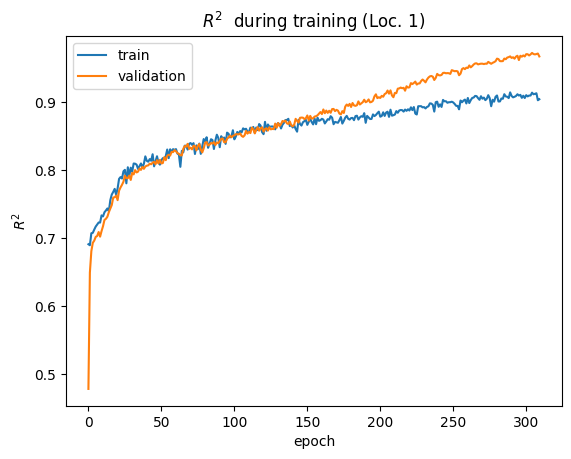

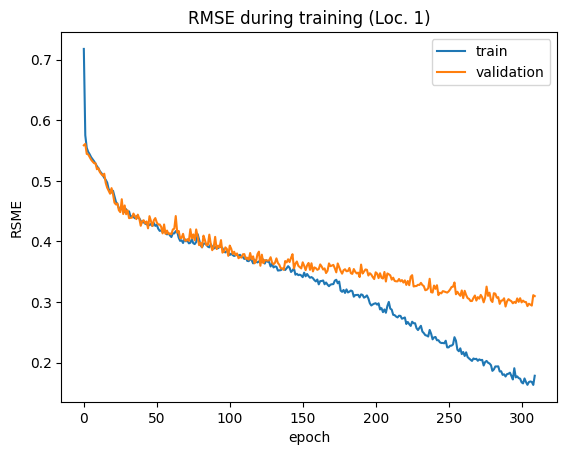

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_r2_score'])
plt.plot(history.history["r2_score"])
plt.title(r'$R^2$  during training (Loc. 1)')
plt.ylabel('$R^2$')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# plot training curve for rmse
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('RMSE during training (Loc. 1)')
plt.ylabel('RSME')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# Model Evaluation
Evaluate the model's performance on the test data using metrics like MSE, RMSE, and R-squared.

In [ ]:
test_df

78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step
 mse_SWTD : 7.956526045897655
 rmse_SWTD : 2.8207314735539173
mae_SWTD : 1.993028326799541
 r2_SWTD : 0.9626204126127292
 MSE_general: 7.956526045897655
 RMSE_general: 2.8207314735539173
r2_general: 0.9626204126127292
mae_general: 1.993028326799541


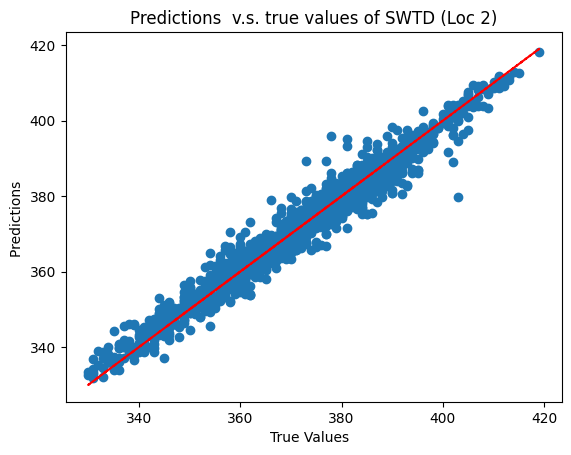

In [ ]:
#preprocess the test set using scaler from the train set
#values=test_df.values
values=scaler.transform(test_df)
test_df3=pd.DataFrame(values, columns=test_df.columns, index=test_df.index)

X_test,Y_test=data_split(train_df, seq_len=7, n_out=n_out, train=False)

yhat = model.predict(X_test)



# invert scaling for actual
X_test_reshape = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
inv_y = np.concatenate((X_test_reshape[:, -(len(df.columns)-n_out):],Y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y=inv_y[:,-n_out:]

#invert scaling for prediction

inv_yhat = np.concatenate((X_test_reshape[:, -(len(df.columns)-n_out):],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,-n_out:]


#calculate the metric
l=['SWTD']

for i in range(n_out):
    mse = mean_squared_error(inv_y[:,i], inv_yhat[:,i])
    r2=r2_score(inv_y[:,i], inv_yhat[:,i])
    mae=mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    rmse=np.sqrt(mse)
    print(f' mse_{l[i]} : {mse}')
    print(f' rmse_{l[i]} : {rmse}')
    print(f'mae_{l[i]} : {mae}')
    print(f' r2_{l[i]} : {r2}')

mse=mean_squared_error(inv_y, inv_yhat)
rmse=np.sqrt(mean_squared_error(inv_y, inv_yhat)    )
mae=mean_absolute_error(inv_y, inv_yhat)
r2=r2_score(inv_y, inv_yhat)

print(f' MSE_general: {mse}')
print(f' RMSE_general: {rmse}')
print(f'r2_general: {r2}')
print(f'mae_general: {mae}')

import matplotlib.pyplot as plt#

#plot the true value vs. Prediction
for i in range(n_out):
    plt.scatter(inv_y[:,i],inv_yhat[:,i])
    plt.plot(inv_y[:,i], inv_y[:,i],'r', linestyle='dashed')
    plt.xlabel('True Values  ')
    plt.ylabel('Predictions ')
    plt.title (f'Predictions  v.s. true values of {l[i]} (Loc 2)')
    plt.show()

# Save the Model
Save the trained LSTM model for future use.

In [ ]:
model.save("../models/LSTM1.keras")